### Torus Geometry
- **Triangular unit cell**: Primitive vectors |G₁|=|G₂| with 120 degree in between
- **Landau level**: n = 0 (lowest Landau level)
- **Brillouin zone area**: 2π/l² = √0.75 × G²
- **Magnetic length**: l = √(ℏ/eB) sets the length scale

### Bilayer Parameters
- **Nc_conserved = 2**: Number of layers (components)
- **Inter-layer distance**: d/l
- **Tunneling amplitude**: t/W0 = 0.0
- **Displacement field**: ΔE/W0, energy difference between layers

### Interaction Details
- **Layer conservation**: Interactions preserve layer index of each particle
- **Layer symmetric**: Interactions unchanged if swap the two layer indices
- **Gate Screening**: D/l
- **Different-layer interaction**: Includes e^{-ql*d/l} attenuation factor
- **Form factor**: See arXiv.2509.07784 Eq.(A28) 

In [1]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED
include("../Landau level triangular.jl")
using .LLT

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(subtitle=nothing)
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
    )
    ax_top = Axis(fig[1, 1];
        xlabel = "momentum block number",
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(subspaces)
        x = Gk[2] * ss_k1[i] + ss_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        for e in energies[i]
            scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
        end
    end
    ax_top.xticks = top_ticks
    if subtitle isa String
        ax_top.subtitle = subtitle
    end
    display(fig)
end

plot_ed_spectrum (generic function with 2 methods)

In [2]:
# Define k-mesh for bilayer system (4×3 mesh, Nk=12) in triangular lattice
k_list = [0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2]
Nk = 12
Gk = (4, 3)  # Grid dimensions


# number of electrons in each layer
Ne1 = 3
Ne2 = 3

# Number of layers (components) for bilayer system
Nc_conserve = 2

2

In [3]:
# Define k-mesh for bilayer system (4×4 mesh, Nk=16) in triangular lattice

#=
k_list = [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
Nk = 16
Gk = (4, 4)  # Grid dimensions

# number of electrons in each layer
Ne1 = 4
Ne2 = 4

# Number of layers (components) for bilayer system
Nc_conserve = 2
=#

In [4]:
# Define k-mesh for bilayer system (4×5 mesh, Nk=20) in triangular lattice
# Note: 32GB memory is insufficient with :spare method
# Use method = :map

#=

k_list = [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
Nk = 20
Gk = (4, 5)  # Grid dimensions

# number of electrons in each layer
Ne1 = 5
Ne2 = 5

# Number of layers (components) for bilayer system
Nc_conserve = 2

=#

In [5]:
ΔE = 0 * LLT.W0                # Energy difference between the two layers

# Set up one-body Hamiltonian matrix for inter-layer tunneling
# H_onebody[c1, c2, cc, k] : no hopping from component c2 to c1
# For bilayer system: Nc_hopping=1, Nc_conserve=2, Nk=6
H_onebody_bilayer_no_tunneling = zeros(ComplexF64, 1, 1, Nc_conserve, Nk)
# Add energy difference terms: ΔE = 0.5 * W0 between different layers
# No tunneling
for k_idx in 1:Nk
    H_onebody_bilayer_no_tunneling[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer_no_tunneling[1, 1, 2, k_idx] = -0.5ΔE
end

# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction(
    (1, 0, 1, 0),
    (2, 0, 1, 0)
);

In [6]:
# Interaction parameters

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
sys_int.d_l = 0.5                  # Inter-layer distance d/l
# compute the pseudo-potential components
intra_PP = LLT.pseudo_potential_decomposition.(0:15; same_layer = true,  D_l = sys_int.D_l, d_l = sys_int.d_l)
inter_PP = LLT.pseudo_potential_decomposition.(0:15; same_layer = false, D_l = sys_int.D_l, d_l = sys_int.d_l)
@show intra_PP
@show inter_PP

# Haldane pseudo-potential
# sys_int.V_intra = [0.0; 0.8; 0.0; 0.4]          # Intralayer Haldane pseudo-potential in unit of W0
# sys_int.V_inter = [1.5; 0.7; 0.5; 0.4]          # Interlayer Haldane pseudo-potential in unit of W0

# or use Coulomb interaction with a cutoff in m
sys_int.V_intra = copy(intra_PP)
sys_int.V_inter = copy(inter_PP)

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 0                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para_conserve = EDPara(
    k_list = k_list, 
    Gk = Gk, 
    Nc_hopping = 1,
    Nc_conserve = Nc_conserve,
    H_onebody = H_onebody_bilayer_no_tunneling,
    V_int = sys_int,
    FF_inf_angle = LLT.Landau_ff_inf(sys_int),
);

intra_PP = [1.634583819831362, 0.7492338495371395, 0.5285404117300112, 0.4186120084649848, 0.35021248081085243, 0.30257119442674524, 0.26703388875010214, 0.23927357356378345, 0.21685643443279629, 0.19829524059065834, 0.18262337867233533, 0.1691818697385912, 0.1575040036341515, 0.14724878200576702, 0.13816050881059833, 0.13004319773047726]
inter_PP = [1.227680253714756, 0.7105139963611995, 0.5157214926633534, 0.41202552162139605, 0.34609651899890626, 0.29971147973612533, 0.26491195947908125, 0.23762722611041615, 0.21553723586872509, 0.1972121254890013, 0.18171700561879395, 0.1684117139218252, 0.1568413327264065, 0.14667258987774875, 0.13765504023537262, 0.1295963774582997]


In [7]:
# Create momentum blocks (Hilbert subspace) for bilayer system
subspaces, ss_k1, ss_k2 = 
    ED_momentum_subspaces(para_conserve, (Ne1, Ne2));
display(length.(subspaces))

# one-body and two-body terms in Hamiltonian
scat1 = ED_sortedScatterList_onebody(para_conserve);
scat2 = ED_sortedScatterList_twobody(para_conserve);

# construct the Hamiltonian operator
hmlt = MBOperator(scat2, scat1; upper_hermitian = true)

12-element Vector{Int64}:
 4036
 4032
 4032
 4036
 4032
 4032
 4036
 4032
 4032
 4036
 4032
 4032

Many Body Operator (upper_hermitian=true) :
	Vector{MomentumED.Scatter{2}} with 1368 scattering terms


In [8]:
Neigen = 10  # Number of eigenvalues to compute per block
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing block #$i with size $(length(subspaces[i])), momentum $(ss_k1[i]), $(ss_k2[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], hmlt;
        N = Neigen, showtime = true, ishermitian = true,
        method = :sparse
    )
end

Processing block #1 with size 4036, momentum 0, 0
  0.521711 seconds (599.54 k allocations: 77.571 MiB, 183.46% compilation time)
  2.905969 seconds (5.56 M allocations: 329.126 MiB, 1.22% gc time, 111.61% compilation time)
Processing block #2 with size 4032, momentum 0, 1
  0.037323 seconds (519 allocations: 45.528 MiB, 25.76% gc time)
  0.182321 seconds (8.76 k allocations: 55.794 MiB, 6.30% gc time)
Processing block #3 with size 4032, momentum 0, 2
  0.032301 seconds (511 allocations: 46.799 MiB, 20.18% gc time)
  0.176365 seconds (8.57 k allocations: 55.663 MiB, 5.68% gc time)
Processing block #4 with size 4036, momentum 1, 0
  0.026936 seconds (511 allocations: 46.874 MiB, 8.10% gc time)
  0.311638 seconds (10.32 k allocations: 65.474 MiB, 39.51% gc time)
Processing block #5 with size 4032, momentum 1, 1
  0.024170 seconds (515 allocations: 46.799 MiB)
  0.178614 seconds (8.09 k allocations: 51.922 MiB, 3.04% gc time)
Processing block #6 with size 4032, momentum 1, 2
  0.032692 se

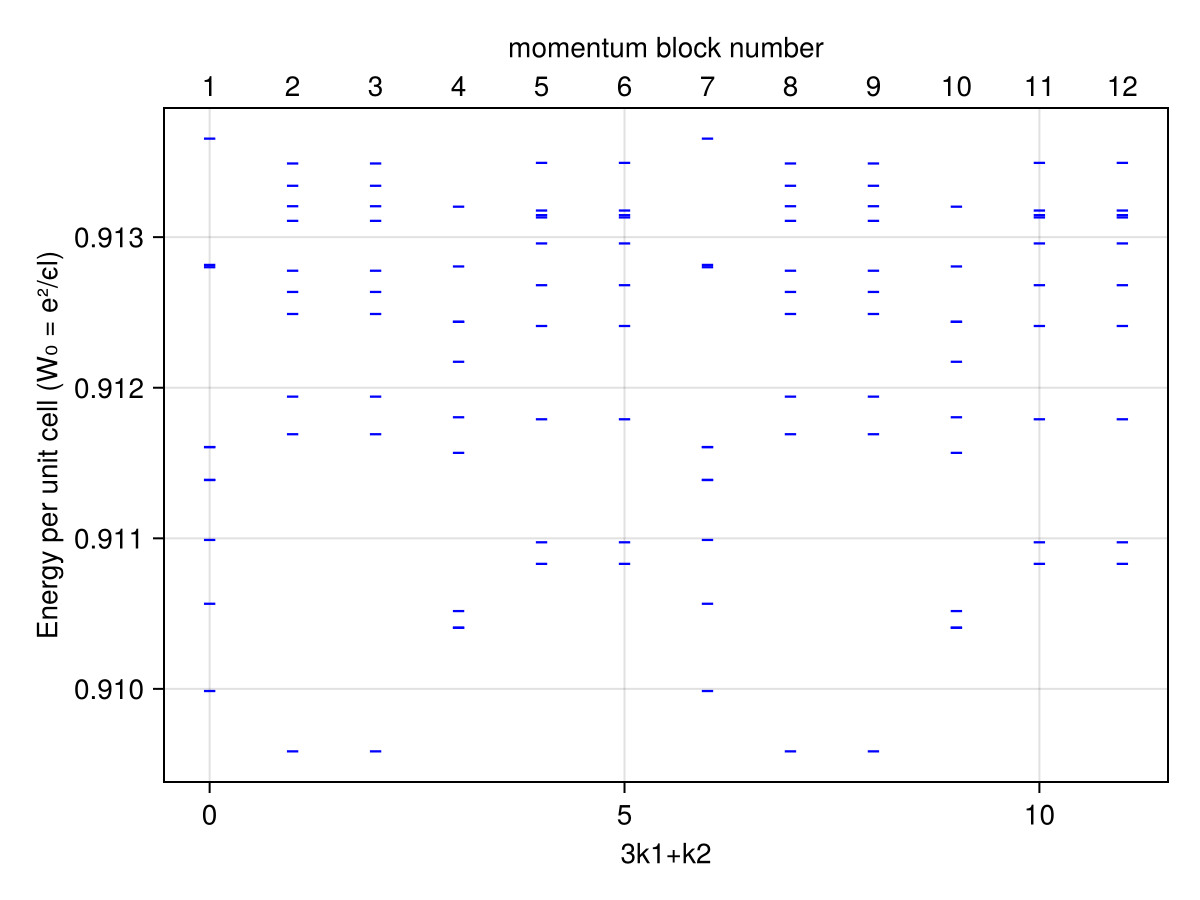

In [9]:
plot_ed_spectrum();

In [ ]:
# check energies explicitly to see degeneracy.

sn = 1 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

total momentum: 0  0


10-element Vector{Float64}:
 0.9099857225616077
 0.9105652539699033
 0.910989031549736
 0.9113874405560444
 0.9113874405560457
 0.9116059183050483
 0.911605918305051
 0.912800228375684
 0.9128156330984308
 0.9136541836375502

Compute and plot one-body reduced density matrix

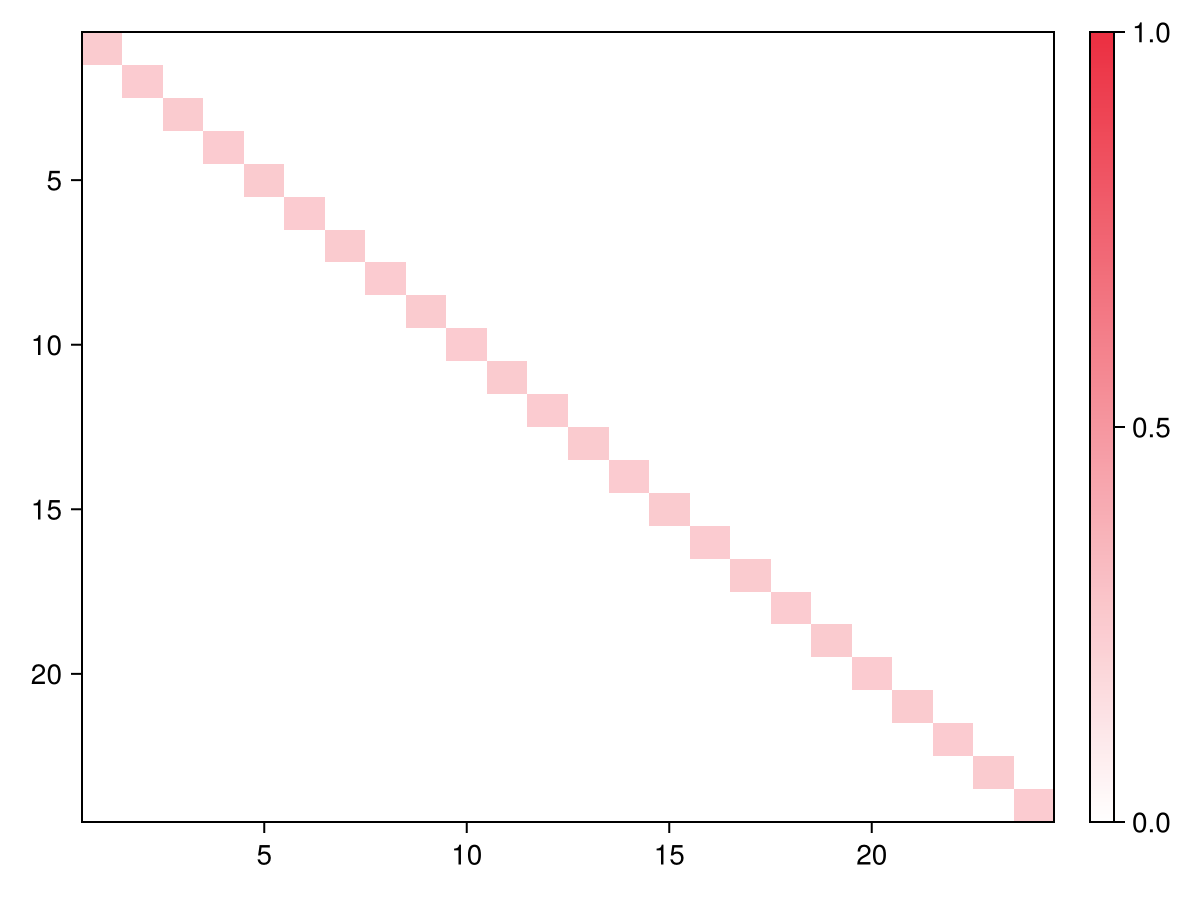

In [11]:
# plot the reduced density matrix of the ground eigenstate in the first block
sn = 1
rdm = ED_onebody_rdm(vectors[sn][1])

fig = Figure();
ax = Axis(fig[1, 1]; yreversed = true)
hm = heatmap!(ax, abs.(rdm); colorrange = (0,1), 
    colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
)
Colorbar(fig[1, 2], hm)
fig

Compute the many-body connection and the Wilson loop for many-body Chern number.

In [12]:
# twist angle path for the Wilson loop integral
N_shift = 10  # number of shifts along each edge
path = Tuple{Float64, Float64}[(0.0, 0.0)]
push!(path, (1/N_shift, 0.0))
push!(path, (1/N_shift, 1/N_shift))
push!(path, (0.0, 1/N_shift))
push!(path, (0.0, 0.0))
path

5-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.1, 0.0)
 (0.1, 0.1)
 (0.0, 0.1)
 (0.0, 0.0)

In [13]:
sn = 2                     # subspace number
nstates = 1                # number of degenerating states

psi_before = vectors[sn][1:nstates]
ED_connection_gaugefixing!(psi_before)  # fix global phase

WilsonLoopIntegral= Vector{Float64}(undef, 4)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    # One-body terms do not change when k are shifted
    scat_list2 = ED_sortedScatterList_twobody(para_conserve; kshift = path[i+1]);
    psi_after = EDsolve(subspaces[sn], scat_list2, scat1; N = 6,
        showtime = false,
    )[2][1:nstates]
    ED_connection_gaugefixing!(psi_after)  # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step( 
        psi_after, psi_before, path[i+1], path[i], para_conserve;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before .= psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π) * N_shift^2


path point #1 	 (0.1, 0.0)
Inner product: amp = 1.000000000000001, phase = -0.026179938779812728
path point #2 	 (0.1, 0.1)
Inner product: amp = 1.0000000000000084, phase = 0.12042771838761844
path point #3 	 (0.0, 0.1)
Inner product: amp = 1.000000000000003, phase = 0.041887902047847606
path point #4 	 (0.0, 0.0)
Inner product: amp = 1.0000000000000004, phase = -0.10471975511970089


0.5000000000008674